# Machine Learning 2024/2025 - Progress Task 2 (Application of Light Hisogram Gradient Boosting)

## Abstract

In an attempt to achieve competitive advancements, the team decided to use some alternative models that were not present under the scikit-learn library. The LightGBM model is a decision-tree-based model from the library `lightgbm`. Given the good performance of catboost and the similarity of this other model to it, the team decided to try it out.

## Introduction

Light Gradient Boosting Machine (LightGBM) is a gradient boosting framework that uses tree-based learning algorithms. It is designed for distributed and efficient gradient boosting, **performing even faster than catboost**. Working within the `lightgbm` library, developers are able to use the model on datasets of millions of samples efficiently, with a set of high-efficiency parameters. The model is also able to handle a methodology called "feature_fraction" which allows it to only handle a set of features within each iteration.

LightGBM uses a leave-based growth strategy, always selecting the best leaf node to divide. This approach may achieve competitive advantage over other models.

### Strengths

* **Speed**: LightGBM is known for its speed and efficiency, being able to handle large datasets with millions of samples.
* **High accuracy**: its leaf-based growth strategy allows it to achieve high accuracy.

### Weaknesses

* **Overfitting**: LightGBM is known to overfit on smaller datasets, so it is important to tune the hyperparameters correctly.
* **Sensitivity to disbalanced datasets**: class ponderation may be required.

## Methodology

The team used the K-Nearest Neighbours algorithm to classify the data. The team used the following hyperparameters:

- n_neighbors: 5
- weights: distance

## Implementation

The team used the following code to implement the K-Nearest Neighbours algorithm:

In [225]:
!pip install pandas lightgbm optuna

Defaulting to user installation because normal site-packages is not writeable


### Initial Configuration

In [226]:
# IMPORTS

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import OneHotEncoder
import logging
import configparser

# GLOBAL VARIABLES

# Load configuration fileconfig["data"]["targets"]
CONFIG_FILE_PATH = "mlflow/test.conf"

config = configparser.ConfigParser()
config.read(CONFIG_FILE_PATH)
DATASET_PATH = config["data"]["dataset_path"]
TEST_DATASET_PATH = config["data"]["dataset_test_path"]
DATASET_INDEX_FEATURE = config["data"]["dataset_index"]
DATASET_TARGET_FEATURES = ["h1n1_vaccine", "seasonal_vaccine"]
CONFIG_SECTION_NAMES = "names"
CONFIG_SECTION_DATA = "data"
CONFIG_PARAM_EXPERIMENT_NAME = "LightGBM"

OPTIMIZED_SUFFIX = config[CONFIG_SECTION_NAMES]["model_optimized"]
ROC_AUC_NAME = config[CONFIG_SECTION_NAMES]["parameter_roc_auc"]
ACCURACY_NAME = config[CONFIG_SECTION_NAMES]["parameter_accuracy"]
OUTPUT_FILE_PATH = config[CONFIG_SECTION_DATA]["output_path"]

# Load logging configuration
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%H:%M:%S' 
)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
tuner_logger = logging.Logger("[Tuner]",level=logging.DEBUG)
tuner_logger.addHandler(ch)

run_logger = logging.Logger("[Run]",level=logging.DEBUG)
run_logger.addHandler(ch)

logger_main = logging.Logger("[Main]",level=logging.DEBUG)
logger_main.addHandler(ch)

### Dataset Setup

In [227]:
# Dataset Class creation

class Dataset:
    '''
    ## Dataset
    
    This class represents a dataset. It handles dataset loading and splitting.
    
    ### Attributes
    
    - test: The test dataset.
    
    '''
    def __init__(self):
        '''
        Constructor for the Dataset class.
        '''
        data = pd.read_csv(DATASET_PATH)
        target = DATASET_TARGET_FEATURES
        data.set_index(DATASET_INDEX_FEATURE, inplace=True)
        self._y = data[target]
        self._X = data.drop(columns=target)
        test_data =  pd.read_csv(TEST_DATASET_PATH)
        test_data.set_index(DATASET_INDEX_FEATURE, inplace=True)
        self.test = test_data
    
    def with_correlation(self):
        '''
        ## with_correlation
        Method that returns a copy of the dataset features and targets.
        
        ### Returns
        (X, y): A tuple containing the dataset features and targets.
        '''
        
        return self._X.copy(), self._y.copy()
    
    def all_features(self):
            '''
            ## all_features
            Method that returns the dataset encoded with all the features without dropping the ones with random values.

            ### Returns
            X, y, test
            '''
            X = pd.read_csv(config["data"]["dataset_all_path"], index_col="respondent_id")
            target = ["h1n1_vaccine","seasonal_vaccine"]
            y = X[target]
            X = X.drop(columns=target)
            test = pd.read_csv(config["data"]["dataset_test_all_path"], index_col="respondent_id")
            return X, y, test    

    def all_onehot(self):
            X,y,test = self.all_features()
            encoder = OneHotEncoder()
            all_features = pd.concat([X, test])
            encoder.fit(all_features)
            encoder.fit(X)
            X = encoder.transform(X)
            test_transformed = encoder.transform(self.test)
            test_df = pd.DataFrame(test_transformed.toarray(), index=self.test.index)
            return X, y, test_df
    

### Execution of the experiment

In order to initialize the model with the best parameters, it is important to fine tune the hyperparameters. In order to do so, the `optuna` library uses a feature called `study` to run several tests with different hyperparameters and select the best one. To carry out the study, a function must be define that fits the model with the hyperparameters and returns the accuracy of the model.

In [228]:
from lightgbm import LGBMClassifier
 
# Set our tracking server uri for logging
experiment_name = CONFIG_PARAM_EXPERIMENT_NAME
logger_main.info("Starting Experiment: " + experiment_name)

# Create a new MLflow Experiment
logger_main.info("fetching data")
data = Dataset()
X, y = data.with_correlation()
output = data.test
logger_main.info("data fetched")

Starting Experiment: LightGBM
fetching data
data fetched


In [229]:
# Split the dataset into train and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

Below, the methods that allow Optuna to run the study are defined:

In [230]:


h1_train = y_train['h1n1_vaccine']
h1_test = y_test['h1n1_vaccine']
seasonal_train = y_train['seasonal_vaccine']
seasonal_test = y_test['seasonal_vaccine']

def objective_h1n1(trial):
    param_dist_random = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'max_depth': trial.suggest_int('max_depth', 4, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 4, 16),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
    }
    model = LGBMClassifier(**param_dist_random)
    model.fit(
        X_train, h1_train,
        eval_set=(X_test, h1_test),  
        eval_metric='AUC'      
    )    

    return model.best_score_['valid_0']['auc']

def objective_seasonal(trial):
    param_dist_random = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'max_depth': trial.suggest_int('max_depth', 4, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 4, 16),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
    }
    model = LGBMClassifier(**param_dist_random)
    model.fit(
        X_train, h1_train,
        eval_set=(X_test, h1_test),
        eval_metric='AUC'     
    )
    return model.best_score_['valid_0']['auc']

Now, the model will be executed after performing a study with Optuna. Once the best parameters are found, the model will be trained with them and will predict on one of the classes. Then, the predictions of both classes will be merged into a single array.

In [231]:
import optuna

optuna.logging.set_verbosity(optuna.logging.ERROR)

################################## Initial logs ##################################
model_name = "LightGBM"
run_logger.info(f"========== Starting initial logging for model {model_name} =========")       
########################## Training, testing and evaluation ######################

# Find the best hyperparameters for the model
# Create study for h1n1_vaccine
study_h1n1 = optuna.create_study(direction='maximize')
tuner_logger.info("Starting Optuna study for h1n1_vaccine...")
study_h1n1.optimize(objective_h1n1, n_trials=200)
tuner_logger.info("Optuna study for h1n1_vaccine completed!")

# Create study for seasonal_vaccine
study_seasonal = optuna.create_study(direction='maximize')
tuner_logger.info("Starting Optuna study for seasonal_vaccine...")
study_seasonal.optimize(objective_seasonal, n_trials=200)
tuner_logger.info("Optuna study for seasonal_vaccine completed!")

# Initialize the model with the best hyperparameters
model_h1n1 = LGBMClassifier(**study_h1n1.best_params)
model_seasonal = LGBMClassifier(**study_seasonal.best_params)
predict = pd.DataFrame({'respondent_id': output.index})

for model in [model_h1n1, model_seasonal]:

    # Train the model
    run_logger.info(f"Training model {model_name}...")
    if model == model_h1n1:
        model.fit(X_train, h1_train)
        
    else:
        model.fit(X_train, seasonal_train) 
    run_logger.info(f"Model {model_name} trained successfully!")
    
    # Predict the test data
    run_logger.info(f"Predicting test data with trained model {model_name}...")
    y_pred = model.predict(X_test)
    run_logger.info(f"Test data predictions finished!")
    # Evaluate the model (get the metrics)
    run_logger.info(f"Evaluating model {model_name}...")
    if model == model_h1n1:
        accuracy = accuracy_score(h1_test, y_pred)
        roc_auc = roc_auc_score(h1_test, y_pred)
        f1 = f1_score(h1_test, y_pred)
    else:
        accuracy = accuracy_score(seasonal_test, y_pred)
        roc_auc = roc_auc_score(seasonal_test, y_pred)
        f1 = f1_score(seasonal_test, y_pred)


    ################################## Result logs ##################################
        
    # Log the model's metrics and information to MLflow
    run_logger.info(f"\nResults for model {model_name}\n-------------------\nROC AUC: {roc_auc}\nAccuracy: {accuracy}\nF1-Score: {f1}\n-------------------\n")
        
    # Predict probabilities for the output data
    if model == model_h1n1:
        h1n1_probs = model.predict_proba(output)[:, 0]
        predict['h1n1_vaccine'] = h1n1_probs
    else:
        seasonal_probs = model.predict_proba(output)[:, 1]
        predict['seasonal_vaccine'] = seasonal_probs
        
# The predictions are indexed by their value of respondent_id
predict.set_index("respondent_id", inplace=True)
        
################################## Final logs ##################################
        
# Store the predictions in a file and log them to MLflow
predict.to_csv(OUTPUT_FILE_PATH) 
run_logger.info("predictions saved")

========== Starting initial logging for model LightGBM =========
Starting Optuna study for h1n1_vaccine...


[LightGBM] [Info] Number of positive: 4824, number of negative: 17876
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 22700, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212511 -> initscore=-1.309856
[LightGBM] [Info] Start training from score -1.309856
[LightGBM] [Info] Number of positive: 4824, number of negative: 17876
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 22700, number of used features: 35
[LightGBM] [Info] [bin

Optuna study for h1n1_vaccine completed!
Starting Optuna study for seasonal_vaccine...


[LightGBM] [Info] Number of positive: 4824, number of negative: 17876
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 22700, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212511 -> initscore=-1.309856
[LightGBM] [Info] Start training from score -1.309856
[LightGBM] [Info] Number of positive: 4824, number of negative: 17876
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000935 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 22700, number of used features: 35
[LightGBM] [Info] [bin

Optuna study for seasonal_vaccine completed!
Training model LightGBM...


[LightGBM] [Info] Number of positive: 4824, number of negative: 17876
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 22700, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.212511 -> initscore=-1.309856
[LightGBM] [Info] Start training from score -1.309856


Model LightGBM trained successfully!
Predicting test data with trained model LightGBM...
Test data predictions finished!
Evaluating model LightGBM...

Results for model LightGBM
-------------------
ROC AUC: 0.7287320427062178
Accuracy: 0.8597454454704268
F1-Score: 0.6025459688826026
-------------------

Training model LightGBM...


[LightGBM] [Info] Number of positive: 10620, number of negative: 12080
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 189
[LightGBM] [Info] Number of data points in the train set: 22700, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.467841 -> initscore=-0.128812
[LightGBM] [Info] Start training from score -0.128812


Model LightGBM trained successfully!
Predicting test data with trained model LightGBM...
Test data predictions finished!
Evaluating model LightGBM...

Results for model LightGBM
-------------------
ROC AUC: 0.7900649242926948
Accuracy: 0.7928624906413776
F1-Score: 0.7688022284122563
-------------------

predictions saved


## Results

For evaluating the model's results, the team used the following metrics:

- Confusion Matrix
- ROC Graph
- ROC AUC Score
- F1 Score

In the following sections, the results will be presented for each of these measurements.

### Confusion Matrix

The confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. Each of the cells in the matrix represents the number of instances of each type of prediction (true positive, true negative, false positive, and false negative) made by the model.

ValueError: Found input variables with inconsistent numbers of samples: [4007, 26707]

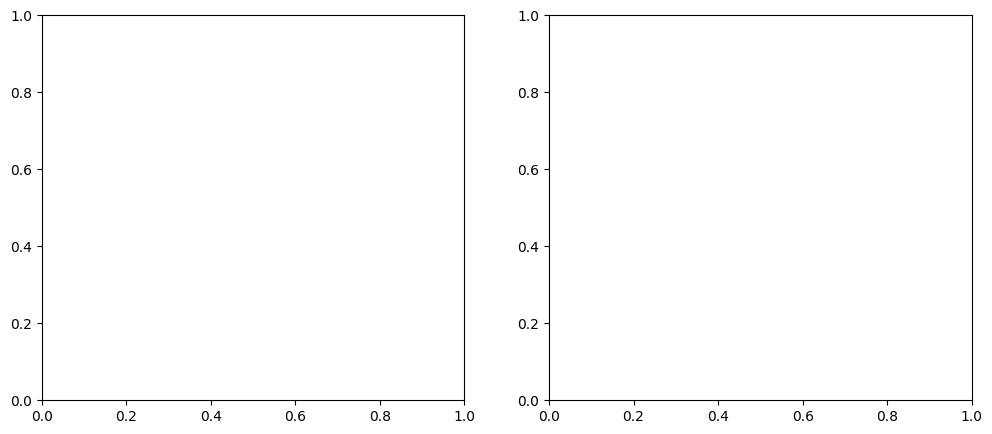

In [233]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Compute confusion matrix for h1n1_vaccine
cm_h1n1 = confusion_matrix(y_test['h1n1_vaccine'], y)
disp_h1n1 = ConfusionMatrixDisplay(confusion_matrix=cm_h1n1, display_labels=[0, 1])
disp_h1n1.plot(ax=ax[0], cmap=plt.cm.Blues)
ax[0].set_title('Confusion Matrix for h1n1_vaccine')

# Compute confusion matrix for seasonal_vaccine
cm_seasonal = confusion_matrix(y_test['seasonal_vaccine'], seasonal_probs)
disp_seasonal = ConfusionMatrixDisplay(confusion_matrix=cm_seasonal, display_labels=[0, 1])
disp_seasonal.plot(ax=ax[1], cmap=plt.cm.Blues)
ax[1].set_title('Confusion Matrix for seasonal_vaccine')

plt.tight_layout()
plt.show()

## Conclusion

This algorithm did not outperform the Random Forest algorithm, which was the best algorithm tested so far with a ROC AUC of 0.75. The team will continue to test other algorithms to find the best one for the dataset.